# Optimal Portoflio

This notebook demonstrates how to use [Markowitz Portfolio](https://www.math.hkust.edu.hk/~maykwok/courses/ma362/07F/markowitz_JF.pdf) optimization to setup an optimal portfolio using the MultiInstrumentEnv. It then goes on to show how to use simple rules to balance the portfolio.

This notebook uses PyPortfolioOpt library to optimize the portfolio. You can install it using the following command:
```bash
pip install PyPortfolioOpt
```

## Methodology

The method exp [MultiInstrumentEnv](../deeptrade/env/multi_instrument.py) allows multiple instruments to be traded together. The following steps are used to setup the environment:

### 1. Load price data either by:
  - Passing a dictionary config with price name and args to generate data, (recommended for baseline comparisons).
  - Generate data and pass the data directly to the environment (shown here).
  - Load real price data, and pass it to the environment.
  Price Data needs to be a numpy array with shape (n_instruments, n_steps), data generation assumes annualized drift and volatility, but data is daily $dt = \frac{1}{252}$, this can easily be changed if a different frequency is desired. 

### 2 Calculate agent-instrument weights
  - The environment is rolled out for a number of steps, and the agent returns are calculated.
  - The agent returns are used to calculate the optimal portfolio weights.
  - This is over the length of the $\mathcal{D}_{\text{train}}$

### 3. Calculate portfolio performance
  - Use the agent-instrument weights to calculate the performance of the portfolio.
  - This is done over the length of the $\mathcal{D}_{\text{backtest}}$
  - Return portfolio statistics. 

In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import deeptrade.env
from deeptrade.env import HoldAgent, EWMACAgent, BreakoutAgent
from deeptrade.models import GBM, OU, JDM
import deeptrade.util.finance as futils

COLOURS = [[0, 18, 25], [0, 95, 115], [10, 147, 150], [148, 210, 189], [233, 216, 166], [238, 155, 0], [202, 103, 2], [187, 62, 3], [174, 32, 18], [155, 34, 38]]
COLOURS = [[value/255 for value in rgb] for rgb in COLOURS]

## Data Generation

To provide data generate several instruments with a range of prices, volatility and correlations.

- 3 equity type instruments that have high volatility and are reasonably correlated.
- 3 rate type instruments, 2 that are correlated and 1 uncorrelated.
- 3 equity index type instruments slightly correlated, and subject to jumps.

In [2]:
seed = 42
n_instruments = 9
starting_cash = 10000.0
num_days = 252 * 5
dt = 1/252

# Risky Equity assets
s0 = np.array([40.0, 100.0, 80.0])
mu = np.array([0.8, 0.6, 0.7])
cov = np.array([[0.9, 0.1, 0.1], 
                [0.1, 0.5, 0.3],
                [0.1, 0.3, 0.7]])
risky_prices = GBM(s0, mu, cov, seed=seed).generate(dt, num_days)

# Rate assets
s0 = np.array([1.05, 0.95, 1.55])
mu0 = np.array([1.00, 0.95, 1.50])
delta = np.array([0.0, 0.0, 0.08])
theta = np.array([0.1, 0.1, 0.9])
sigma = np.array([0.5, 0.3, 0.4])
corr = np.array([[1.0,  0.3,  0.01],
                 [0.3,  1.0,  0.01],
                 [0.01, 0.01, 1.0]])
rate_prices = OU(s0, mu0, delta, theta, sigma, corr, seed=seed).generate(dt, num_days)

# Indexs
s0 = np.array([5600.0, 7200.0, 8500.0])
mu = np.array([0.5, 0.3, 0.4])
cov = np.array([[0.9, 0.1, 0.5], 
                [0.3, 0.5, 0.3],
                [0.1, 0.3, 0.7]])
jump_lambda = 0.1
mu_j = np.array([0.2, 0.5, 0.1])
sigma_j = np.array([0.2, 0.3, 0.1])
index_prices = JDM(s0, mu, cov, jump_lambda, mu_j, sigma_j, seed=seed).generate(dt, num_days)

price_data = np.concatenate([risky_prices, rate_prices, index_prices], axis=0)
print(price_data.shape)

(9, 1261)


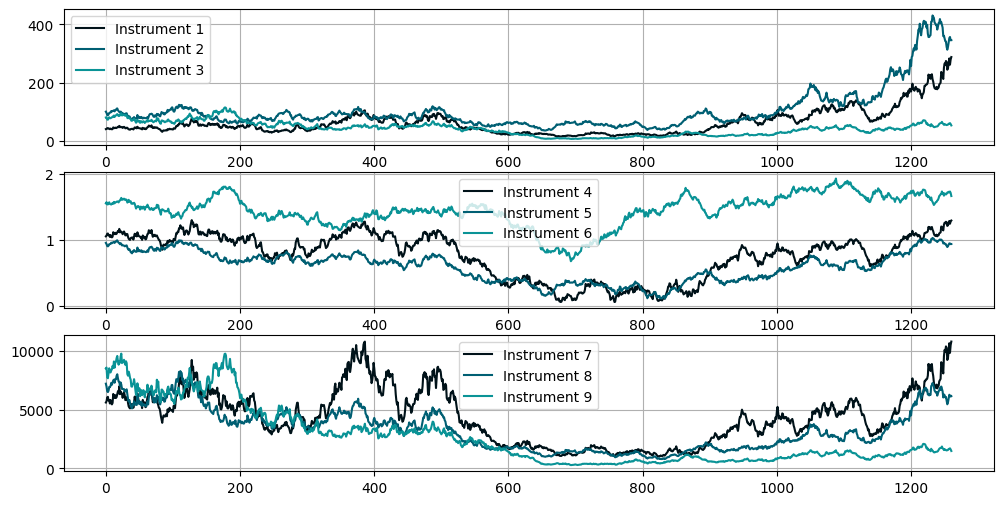

In [3]:
fig, ax = plt.subplots(3, 1, figsize=(12, 6))
for idg, prices in enumerate([risky_prices, rate_prices, index_prices]):
    for idi in range(3):
        ax[idg].plot(prices[idi], color=COLOURS[idi], label=f'Instrument {idg*3 + idi + 1}')
    ax[idg].grid()
    ax[idg].legend()

In [4]:
env = gym.make('MultiInstrument-v0',
               prices_data=price_data,
               n_instruments=n_instruments,
               starting_cash=starting_cash,
               seed=seed)

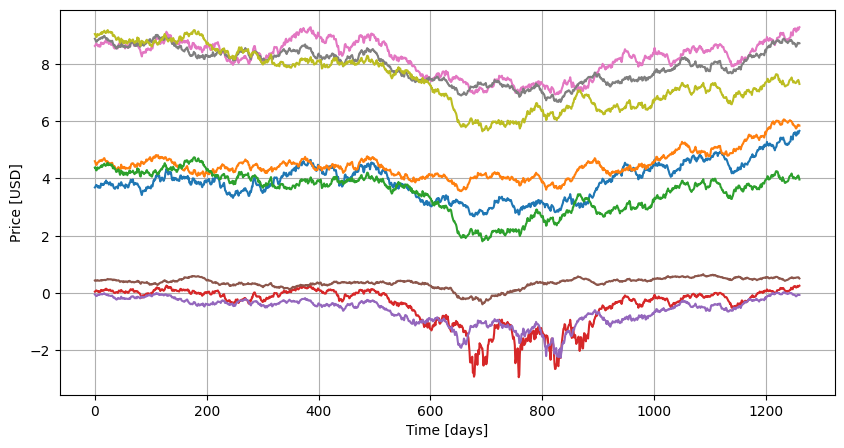

In [5]:
price_data = env.unwrapped.prices_data
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in range(n_instruments):
    ax.plot(np.log(price_data[i]), label=f"Instrument {i}")
ax.grid()
# ax.legend()
ax.set_ylabel("Price [USD]")
ax.set_xlabel("Time [days]")
fig.show()

In [6]:
from pypfopt import risk_models
from pypfopt import plotting

dates = pd.date_range(start='1990-01-01', periods=price_data.shape[1], freq='D')
prices = pd.DataFrame(price_data.T, index=dates, columns=[f'Asset {i+1}' for i in range(price_data.shape[0])])
sample_cov = risk_models.sample_cov(prices, frequency=252)
sample_cov

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9
Asset 1,0.901498,0.106185,0.075422,0.945492,0.163374,-0.006807,0.901166,0.304596,0.078941
Asset 2,0.106185,0.505165,0.326207,0.084169,0.448567,0.012843,0.106529,0.481681,0.332547
Asset 3,0.075422,0.326207,0.728498,0.047531,0.301143,0.216574,0.076400,0.312660,0.726486
Asset 4,0.945492,0.084169,0.047531,2.078964,0.225613,-0.013019,0.944613,0.295284,0.049372
Asset 5,0.163374,0.448567,0.301143,0.225613,0.549596,0.015740,0.163468,0.443653,0.306460
Asset 6,-0.006807,0.012843,0.216574,-0.013019,0.015740,0.088632,-0.006434,0.010100,0.214351
Asset 7,0.901166,0.106529,0.076400,0.944613,0.163468,-0.006434,0.906672,0.304844,0.079908
Asset 8,0.304596,0.481681,0.312660,0.295284,0.443653,0.010100,0.304844,0.506415,0.319214
Asset 9,0.078941,0.332547,0.726486,0.049372,0.306460,0.214351,0.079908,0.319214,0.730572


<Axes: >

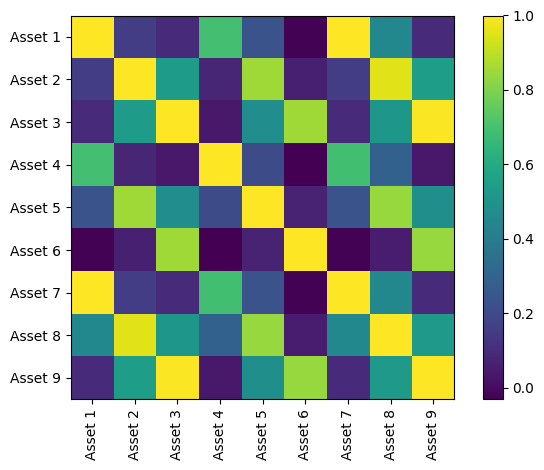

In [7]:
plotting.plot_covariance(sample_cov, plot_correlation=True)

<Axes: >

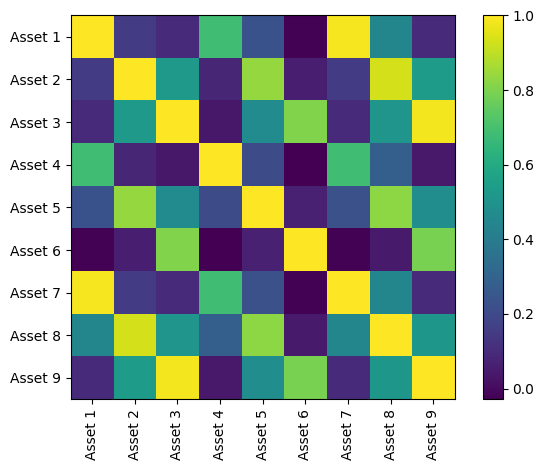

In [8]:
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
plotting.plot_covariance(S, plot_correlation=True)

Asset 1    0.359511
Asset 2    0.255210
Asset 3    0.295036
Asset 4    0.475766
Asset 5    0.276122
Asset 6    0.072052
Asset 7    0.360225
Asset 8    0.311428
Asset 9    0.297671
Name: mkt, dtype: float64
0.3149339608406227 0.590664794583294


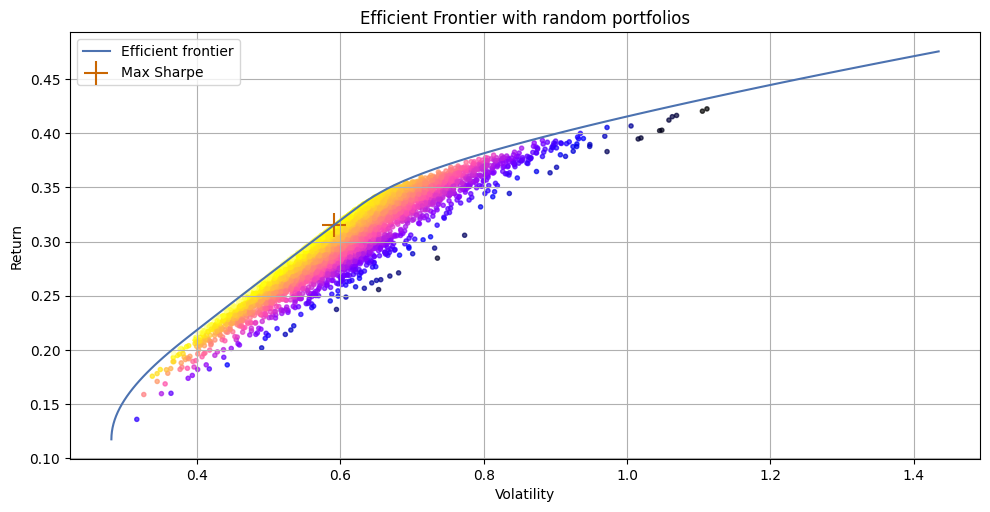

In [9]:
from pypfopt import EfficientFrontier
from pypfopt import expected_returns
mu = expected_returns.capm_return(prices)
ef = EfficientFrontier(mu, S)
print(mu)

n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

fig, ax = plt.subplots(figsize=(10, 5))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False, verbose=True)

ef2 = EfficientFrontier(mu, S)
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
print(ret_tangent, std_tangent)
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="gnuplot2", alpha=0.7)
ax.scatter(std_tangent, ret_tangent, marker="+", s=300, color=COLOURS[6], label="Max Sharpe")
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
ax.grid()
# fig.tight_layout()
fig.show()


In [10]:
pos_size = 0.01
agents = [HoldAgent, EWMACAgent, BreakoutAgent]
names = ["Hold", "EWMAC", "Breakout"]

agent_margins = {}

for agent_type, name in zip(agents, names):
    margins = {}
    for idi in range(n_instruments):
        agent = agent_type(env=env, pos_size=pos_size, instrument=idi)
        env.reset(seed=seed)
        terminated, truncated = False, False
        observations = []
        times = []
        obs, _ = env.reset(seed=seed)
        while (not terminated) and (not truncated):
            action = np.zeros(n_instruments)
            action[idi] = agent.act(obs)[idi]
            obs, reward, terminated, truncated, _ = env.step(action)
            observations.append(obs)

        observations = np.array(observations)
        margins[idi] = [obs['margin'] for obs in observations]
    agent_margins[name] = margins

/home/quessy/.conda/envs/deeptrade-env/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/quessy/.conda/envs/deeptrade-env/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/quessy/.conda/envs/deeptrade-env/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:245: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'numpy.ndarray'>
  logger.warn(
/home/quessy/.conda/envs/deeptrade-env/lib/python3.10/site-packages/deeptrade/env/agents/ewmac.py:43: RuntimeWarning: Mean of empty slice.
  slow = np.array(price_data[self.instrument][time-self.sl

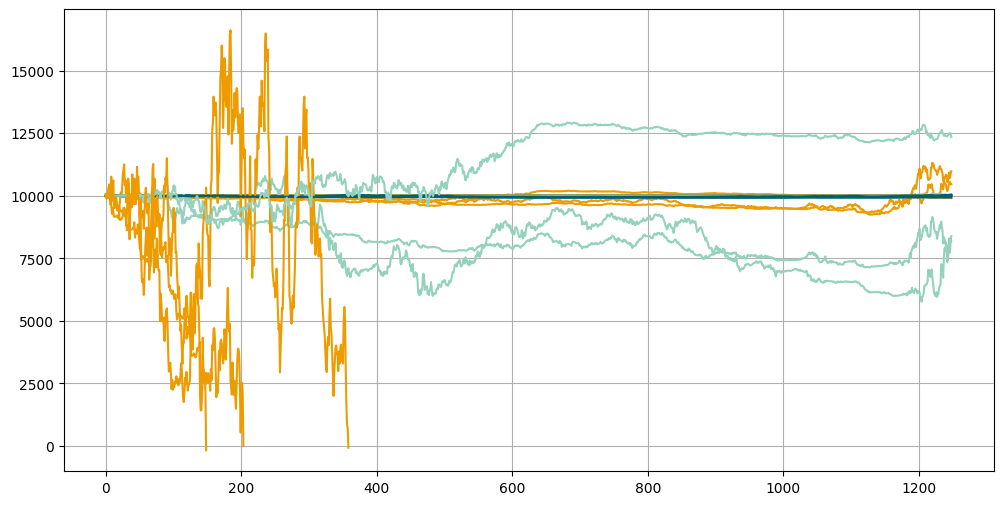

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# ax.plot(times, margins, label='Margin')
# print(agent_margins)
for idp in range(n_instruments):
    ax.plot(agent_margins["Hold"][idp], label=f"Margin {idp}", color=COLOURS[1])
    ax.plot(agent_margins["EWMAC"][idp], label=f"Margin {idp}", color=COLOURS[3])
    ax.plot(agent_margins["Breakout"][idp], label=f"Margin {idp}", color=COLOURS[5])
# ax.plot(times, prices[0, :len(times)])
ax.grid()

/home/quessy/.conda/envs/deeptrade-env/lib/python3.10/site-packages/pypfopt/expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna(how="all")
/home/quessy/.conda/envs/deeptrade-env/lib/python3.10/site-packages/pypfopt/expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna(how="all")


Asset Hold 0        0.020002
Asset Hold 1        0.020002
Asset Hold 2        0.020002
Asset Hold 3        0.020000
Asset Hold 4        0.020000
Asset Hold 5        0.020000
Asset Hold 6        0.020248
Asset Hold 7        0.020195
Asset Hold 8        0.020195
Asset EWMAC 0       0.019878
Asset EWMAC 1       0.019919
Asset EWMAC 2       0.019934
Asset EWMAC 3       0.019999
Asset EWMAC 4       0.020000
Asset EWMAC 5       0.020000
Asset EWMAC 6       0.005869
Asset EWMAC 7       0.016928
Asset EWMAC 8       0.010467
Asset Breakout 0    0.019234
Asset Breakout 1    0.018717
Asset Breakout 2    0.019364
Asset Breakout 3    0.019994
Asset Breakout 4    0.019991
Asset Breakout 5    0.019999
Asset Breakout 6   -0.215190
Asset Breakout 7   -0.125213
Asset Breakout 8   -0.058723
Name: mkt, dtype: float64
Expected annual return: 2.0%
Annual volatility: 6.3%
Sharpe Ratio: -0.01


ArpackNoConvergence: ARPACK error -1: ARPACK error -1: No convergence (271 iterations, 0/1 eigenvectors converged)


        CVXPY note: This failure was encountered while trying to certify
        that a matrix is positive semi-definite (see [1] for a definition).
        In rare cases, this method fails for numerical reasons even when the matrix is
        positive semi-definite. If you know that you're in that situation, you can
        replace the matrix A by cvxpy.psd_wrap(A).

        [1] https://en.wikipedia.org/wiki/Definite_matrix
        

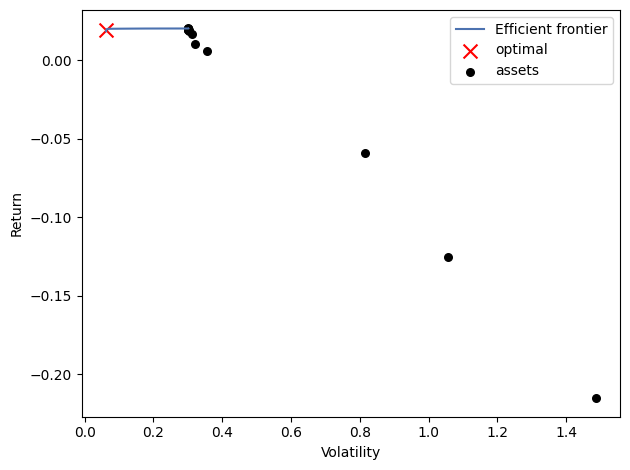

In [12]:
dfs = []

for name in names:
    max_length = max(len(m) for m in agent_margins[name].values())
    padded_margins = {k: np.pad(v, (0, max_length - len(v)), constant_values=np.nan) for k, v in agent_margins[name].items()}
    data = pd.DataFrame(padded_margins)
    dates = pd.date_range(start='1990-01-01', periods=data.shape[0], freq='D')
    df = pd.DataFrame(data.values, index=dates, columns=[f'Asset {name} {ida}' for ida in range(data.shape[1])])
    # print(df)
    dfs.append(df)

combined_df = pd.concat(dfs, axis=1)
sample_cov = risk_models.sample_cov(combined_df, frequency=252)
mu = expected_returns.capm_return(combined_df)
# mu.plot.barh(figsize=(10, 5))
from pypfopt import CLA, plotting
print(mu)
S = risk_models.CovarianceShrinkage(combined_df).ledoit_wolf()
cla = CLA(mu, S)
cla.max_sharpe()
cla.portfolio_performance(verbose=True)
ax = plotting.plot_efficient_frontier(cla, showfig=False)

# ef = EfficientFrontier(mu, sample_cov)

# fig, ax = plt.subplots(figsize=(10, 5))
# plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False, verbose=True)

# ef2 = EfficientFrontier(mu, sample_cov)
# ef2.max_sharpe()
# ret_tangent, std_tangent, _ = ef2.portfolio_performance()
# print(ret_tangent, std_tangent)
# ax.scatter(stds, rets, marker=".", c=sharpes, cmap="gnuplot2", alpha=0.7)
# ax.scatter(std_tangent, ret_tangent, marker="+", s=300, color=COLOURS[6], label="Max Sharpe")
# ax.set_title("Efficient Frontier with random portfolios")
# ax.legend()
# ax.grid()
# # fig.tight_layout()
# fig.show()

ef = EfficientFrontier(mu, S)
# ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.efficient_risk(target_volatility=0.1)
ef.portfolio_performance(verbose=True)
weights = ef.clean_weights()
weights


## Putting it all together

To design a complete portfolio based on these trading rules:
1. Simulate the performance of each agent on each instrument
2. Calculate the expected return and covariance matrix of the returns of each agent
3. Use Markowitz Portfolio optimization to find the optimal portfolio weights
4. Backtest this strategy on the MultiInstrumentEnv